<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<center>
<H1 align='center'> INF-395 Redes Neuronales Artificiales 2019-1</H1>

<H3 align='center'> Tarea 2 - Redes Neuronales y *Deep Learning* </H3>
</center>
<hr style="height:2px;border:none"/>

## Integrantes

* _**Francisco Olivares - 201473575-8 - fracisco.olivars.14@sansano.usm.cl**_
* _**Felipe Vega - 201473511-1 - felipe.vega.14@sansano.usm.cl**_



<hr style="height:2px;border:none"/>

In [43]:
import numpy as np
import os 
import matplotlib.pyplot as plt
from PIL import Image
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from sklearn.decomposition import PCA

from keras.models import Sequential, Model
from keras.layers import merge, Dropout, Conv2D, MaxPool2D, Conv2DTranspose, UpSampling2D, BatchNormalization, Input
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.regularizers import l1,l2
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

from skimage import filters

from IPython.display import SVG
from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

En el siguiente experimento se experimentará con el uso de redes neuronales para realizar _**image segmentation**_, que es un proceso en que se particiona una imagen digital en múltiples segmentos de interés, con el objetivo de simplificarla y/o cambiar su representación en algo con más significado y fácil de analizar. Esta tarea tiene múltiples aplicaciones, donde se puede destacar el uso medicinal para la detección de distintas patologías, y la detección de distintos objetos, la cual es el núcleo de los autos de conducción automática.

Se utiliza un dataset utilizado para realizar benchmark en el área, el cual es bastante pequeño, lo que supone un gran problema al momento de entrenar las redes que se diseñan.

A continuación se carga el dataset a utilizar, donde se destaca el redimensionamiento de las imágenes, pues no todas cuentan con las mismas dimensiones. Se elige utilizar imágenes de _**(100 x 100)**_, cuyo criterio de elección fue ir subiendo poco a poco las dimensiones desde _**(32 x 32)**_ hasta que la visualización de la imagen fuera agradable a la vista.

In [3]:
def charge_images(img_size, folder):
    X_image= []
    data = [archivo.split(".")[0] for archivo in os.listdir(folder+"/image")]
    for archivo in data:
        I = Image.open("{}/image/{}.jpg".format(folder,archivo))
        I = np.asarray(I.resize((img_size,img_size),Image.ANTIALIAS))
        X_image.append(I)
    X_image = np.asarray(X_image)
    Y_image = []
    for archivo in data:
        I = Image.open("{}/ground-truth/{}.png".format(folder,archivo))
        I = np.asarray(I.resize((img_size,img_size),Image.ANTIALIAS))
        Y_image.append(I)
    Y_image = np.asarray(Y_image)
    return X_image, Y_image
        

In [4]:
img_size = 100
img_shape = (100,100,3)
folder = "Semantic dataset100"

In [5]:
X_image, Y_image = charge_images(img_size,folder)

> _**a) Explore los datos a trabajar, visualice la entrada y salida del modelo, además de las dimensionalidades de éstas ¿Es un problema las dimensiones de los datos versus la cantidad de datos a entrenar? Normalice los datos como se acostumbra en imágenes y genere una dimensión/canal extra a la salida.**_

El dataset se compone de 200 imágenes: 100 que se utilizarán como input y 100 que cuentan con la segmentación de la imagen deseada. Cada una de estas imágenes posee 3 canales (RGB). Tal como se mencionó anteriormente, cada uno de estos canales es de $100 x 100$. Hay que destacar que la salida debería ser de un solo canal, el cual no está presente en el dataset original, por lo que es necesario agregar esta dimensión en dicho conjunto.

A continuación se presentan 9 imágenes, con su respectiva salida, elegidas aleatoriamente desde el conjunto completo.

In [6]:
X_image.shape

(100, 100, 100, 3)

In [7]:
Y_image.shape

(100, 100, 100)

In [8]:
def show_9_images(X_image,Y_image):
    plt.figure(figsize=(10,40))
    for i in range(1,20,2):
        random = np.random.randint(0,X_image.shape[0])
        plt.subplot(10,2,i)
        plt.imshow(X_image[random])
        plt.subplot(10,2,i+1)
        plt.imshow(Y_image[random])
    plt.show()

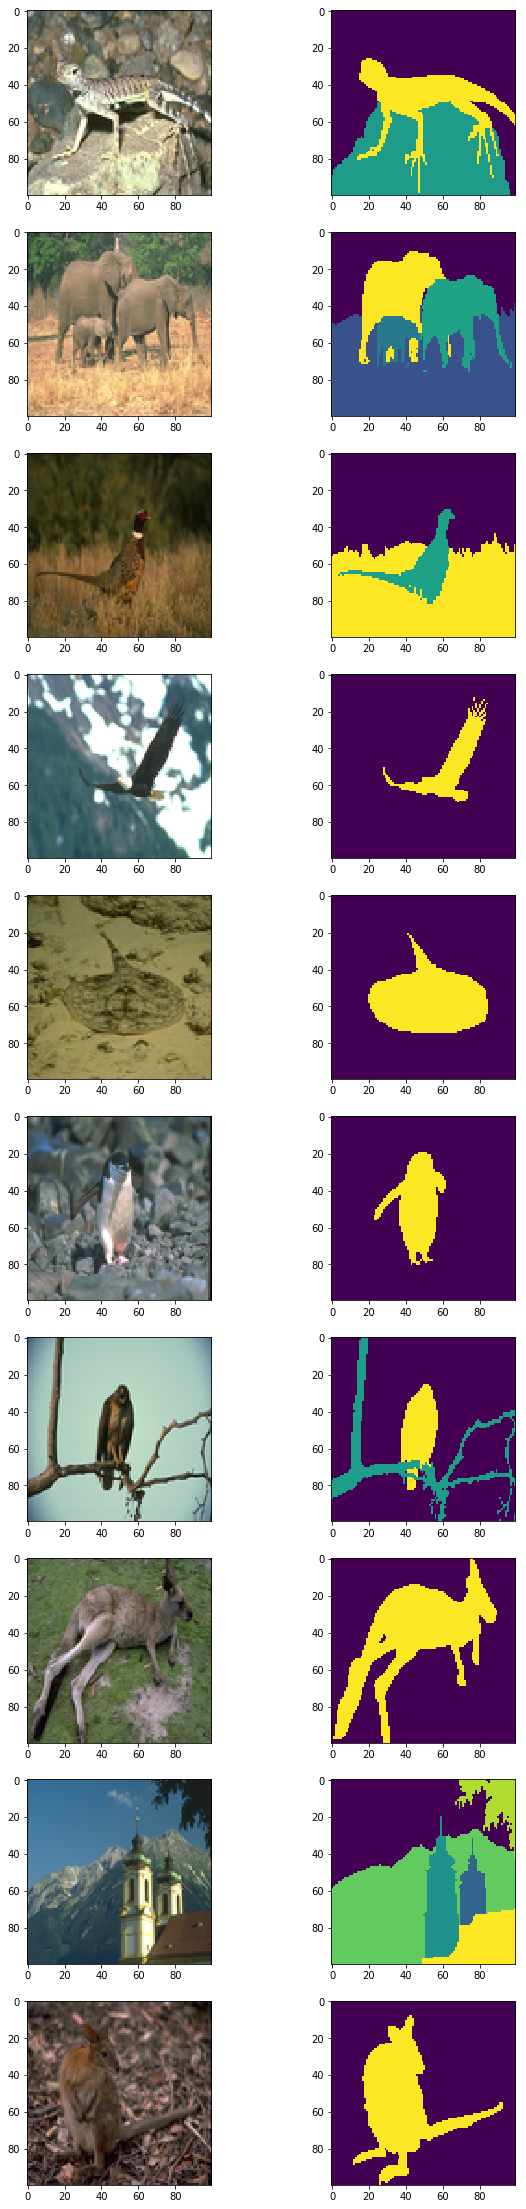

In [9]:
show_9_images(X_image,Y_image)

Tal como se puede observar en las imágenes, a pesar de contar con tan pocas imágenes, estas tienen temáticas muy distintas entre sí (personas, paisajes, animales, medios de transporte, etc), por lo que la poca cantidad de imágenes dificultará la detección de patrones dentro de estas, dada su dispersión en terminos de contenido.

Como es habitual al trabajar con imágenes, se normalizan los pixeles de estas dividiendo por $255$, el cual es el máximo valor al utilizar imágenes RGB.

In [10]:
X_image = X_image/255.
Y_image = Y_image/255.
Y_image = Y_image[:,:,:,None]

Tal como se vió en las imágenes anteriores, la salida tiene distintas intensidades de pixeles, por lo que el problema a resolver se trata de segmentación de imágenes en múltiples segmentos. Entre todas las imágenes del conjunto existen 63 intensidades distintas para los pixeles.

In [33]:
print(np.unique(Y_image))
len(np.unique(Y_image))

[0.         0.02745098 0.15686275 0.23529412 0.24705882 0.25098039
 0.2627451  0.28235294 0.28627451 0.29019608 0.29411765 0.29803922
 0.30980392 0.32156863 0.3254902  0.32941176 0.35686275 0.37254902
 0.38823529 0.39215686 0.40392157 0.41960784 0.42352941 0.43529412
 0.43921569 0.45490196 0.47058824 0.48235294 0.49803922 0.50196078
 0.51372549 0.51764706 0.52941176 0.54901961 0.56078431 0.56470588
 0.56862745 0.57254902 0.57647059 0.59215686 0.60784314 0.62352941
 0.63921569 0.70196078 0.70588235 0.70980392 0.71764706 0.73333333
 0.74901961 0.76078431 0.76470588 0.78039216 0.82745098 0.84705882
 0.85882353 0.8627451  0.87843137 0.88235294 0.89019608 0.9254902
 0.98823529 0.99607843 1.        ]


63

> _**b) Separe 10 imágenes como conjunto de pruebas para verificar la calidad del modelo entrenado.**_

Se separan los conjunto de 100 imágenes en los clásicos conjuntos de entrenamineto y de pruebas. Como se cuenta con tan pocas imágenes, el conjunto de pruebas cuenta solo con 10 imágenes, dejando 90 para el entrenamiento de las redes a utilizar.

In [34]:
x_train, x_test, y_train, y_test = train_test_split(X_image,Y_image,test_size=0.1,random_state=42) 

In [35]:
x_test.shape

(10, 100, 100, 3)

> _**c) Debido a la poca cantidad de datos presentes defina la arquitectura utilizando únicamente convolucionales (fully convolutional). Comente sobre los cambios en la dimensionalidad a través del forward pass. Decida el tamaño del batch en base a la cantidad de datos que se presenta para entrenar.**_

Debido a la poca cantidad de datos en los conjuntos, se utilizará una arquitectura _**fully convolutional**_, la cual cuenta solo con capas convolucionales evitando capas _**fully connected**_, para que no aumente mucho el número de parámetros y evitar overfit.

Además, la arquitectura será del tipo _**encoder-decoder**_, en la cual la red se separa en dos partes: el encoder, el cual va realizando transformaciones mientras baja la dimensionalidad; y el decoder, el cual toma la representación de menor dimensionalidad entregada por el encoder y aumenta la dimensionalidad hasta generar la salida de la imagen.

En este caso, utilizando el código brindado como ejemplo, para el encoder se utilizará la configuración de dos capas convolucionales seguidas de una capa de pooling, reduciendo las dimensiones de $100 x 100$ a $50 x 50$ y luego a $25 x 25$, aumentando los filtros del input en potencias de 2, comenzando con $32$ y terminando con $128$. Para el decoder, se utilizará una capa de up-sampling seguida de dos capas convolucionales transpuestas sin strides, dejando la imagen de $50 x 50$, finalizando con una nueva capa convolucional transpuesta, esta vez con strides $2 x 2$, para obtener como salida una imagen de $100 x 100$ con 3 canales. Por otro lado, se utilizarán activaciones ReLu para cada capa salvo la capa final que es sigmoidal. Lo anterior debido a que esperamos pixeles con valores entre 0 y 1. La función de perdida a utilizar será _**binary crossentropy**_, pues se verá este problema como uno de clasificación pixel a pixel.

In [36]:
def get_convolutional():
    model = Sequential()
    #Lets do the Encoder
    model.add(Conv2D(32,(3,3),activation='relu',padding='same',input_shape=X_image.shape[1:]))
    model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
    model.add(MaxPool2D((2,2)))
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(MaxPool2D((2,2)))
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    #Decoder Time
    model.add(UpSampling2D((2,2)))
    model.add(Conv2DTranspose(32,(3,3),activation='relu',padding='same'))
    model.add(Conv2DTranspose(32,(3,3),activation='relu',padding='same'))
    model.add(Conv2DTranspose(1,(3,3),strides=(2,2),activation='sigmoid',padding='same'))
    model.summary()
    model.compile(loss='binary_crossentropy',optimizer='rmsprop')
    return model

In [44]:
conv_model = get_convolutional()
plot_model(conv_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 25, 25, 128)       73856     
__________

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.

In [16]:
train_hist = conv_model.fit(x_train,y_train,epochs=100,batch_size=30,validation_data=(x_test,y_test))

Train on 90 samples, validate on 10 samples
Epoch 1/100
90/90 [==============================] - 10s 117ms/step - loss: 1.1547 - val_loss: 0.6692
Epoch 2/100
90/90 [==============================] - 2s 21ms/step - loss: 0.6626 - val_loss: 0.6561
Epoch 3/100
90/90 [==============================] - 2s 21ms/step - loss: 0.6449 - val_loss: 0.6670
Epoch 4/100
90/90 [==============================] - 2s 21ms/step - loss: 0.6452 - val_loss: 0.6310
Epoch 5/100
90/90 [==============================] - 2s 21ms/step - loss: 0.6263 - val_loss: 0.6713
Epoch 6/100
90/90 [==============================] - 2s 21ms/step - loss: 0.6493 - val_loss: 0.6552
Epoch 7/100
90/90 [==============================] - 2s 21ms/step - loss: 0.6365 - val_loss: 0.6067
Epoch 8/100
90/90 [==============================] - 2s 21ms/step - loss: 0.6221 - val_loss: 0.6314
Epoch 9/100
90/90 [==============================] - 2s 21ms/step - loss: 0.6369 - val_loss: 0.6691
Epoch 10/100
90/90 [==============================] - 

In [17]:
def loss_versus_epoch(hist):
    plt.figure(figsize=(15,5))
    plt.title("Loss versus Epoch")
    eps = [i + 1 for i in range(100)]
    plt.plot(eps, hist.history['loss'],'-o')
    plt.plot(eps,hist.history['val_loss'],'-o')
    plt.xlabel("Epochs")
    plt.ylabel("Binary Crossentropy Loss")
    plt.legend(['Train','Test'],loc='upper right')
    plt.show()

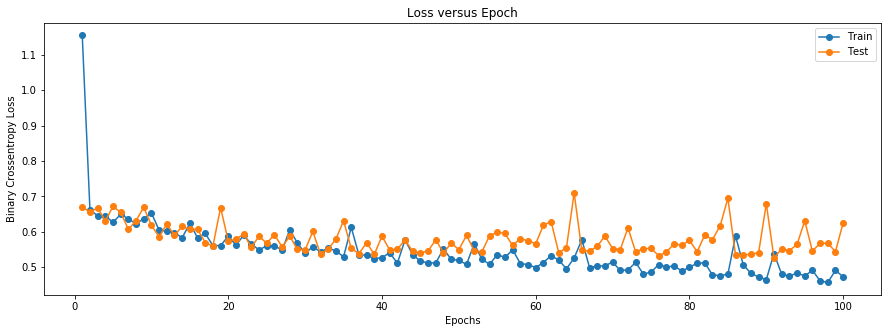

In [18]:
loss_versus_epoch(train_hist)

> _**d) Para medir el desempeño del modelo sobre ambos conjuntos realice un análisis cualitativo en base a visualizar la segmentación que realiza versus la segmentación real, además de verificar la precisión y recall asumiendo valores binarios de pixel ¿Que valor debería ser más importante, los ceros o unos? Comente.**_

In [19]:
def recall_and_precision(pred,dataset='test'):
    if dataset=='test':
        data = np.squeeze(y_test)
    else:
        data = np.squeeze(y_train)
    y_label = data.flatten() > 0.5
    y_hat_label = pred.flatten() > 0.5
    print("Precision in {} dataset: {}".format(dataset,precision_score(y_label,y_hat_label,average=None,labels=[0,1])))
    print("Recall in {} dataset: {}".format(dataset,recall_score(y_label,y_hat_label,average=None,labels=[0,1])))

In [20]:
def compare_images(model,dataset='test'):
    np.random.seed(42)
    if dataset == 'test':
        y_hat = np.squeeze(model.predict(x_test))
        data = y_test
        x_data = x_test
    else:
        y_hat = np.squeeze(model.predict(x_train))
        data = y_train
        x_data = x_train
    recall_and_precision(y_hat,dataset)
    plt.figure(figsize=(20,40))
    for i in range(1,30,3):
        random = np.random.randint(0,data.shape[0])
        plt.subplot(10,3,i)
        plt.title("Real Image")
        plt.imshow(np.squeeze(x_data[random]))
        plt.subplot(10,3,i+1)
        plt.title("Convolutional Network Segmentation")
        plt.imshow(y_hat[random])
        plt.subplot(10,3,i+2)
        plt.title("Real Segmentation")
        plt.imshow(np.squeeze(data[random]))
        
    plt.show()

#### Train dataset

Precision in train dataset: [0.84957115 0.56830653]
Recall in train dataset: [0.73640917 0.72686979]


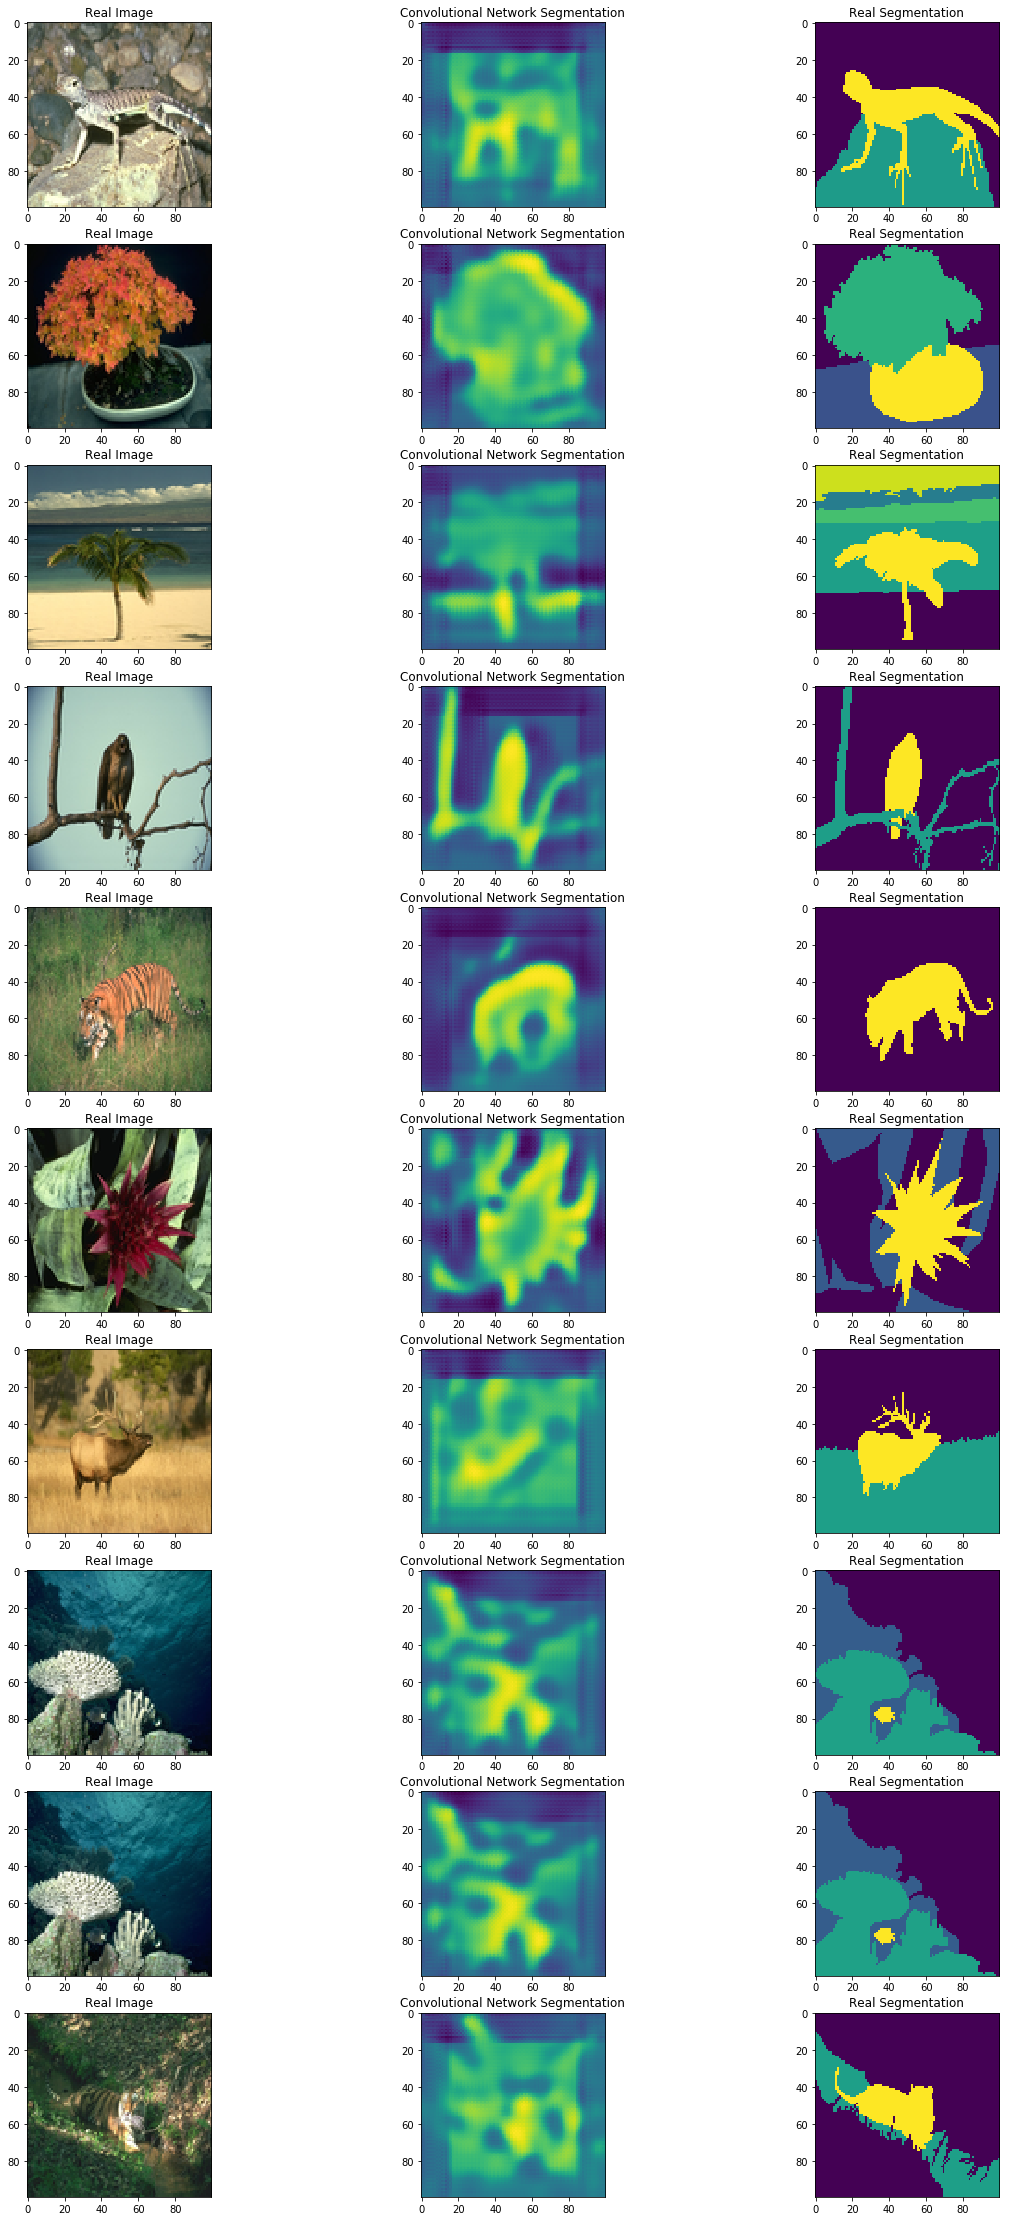

In [21]:
compare_images(conv_model,dataset='train')

#### Test Dataset

Precision in test dataset: [0.82328609 0.45624643]
Recall in test dataset: [0.62783799 0.69854012]


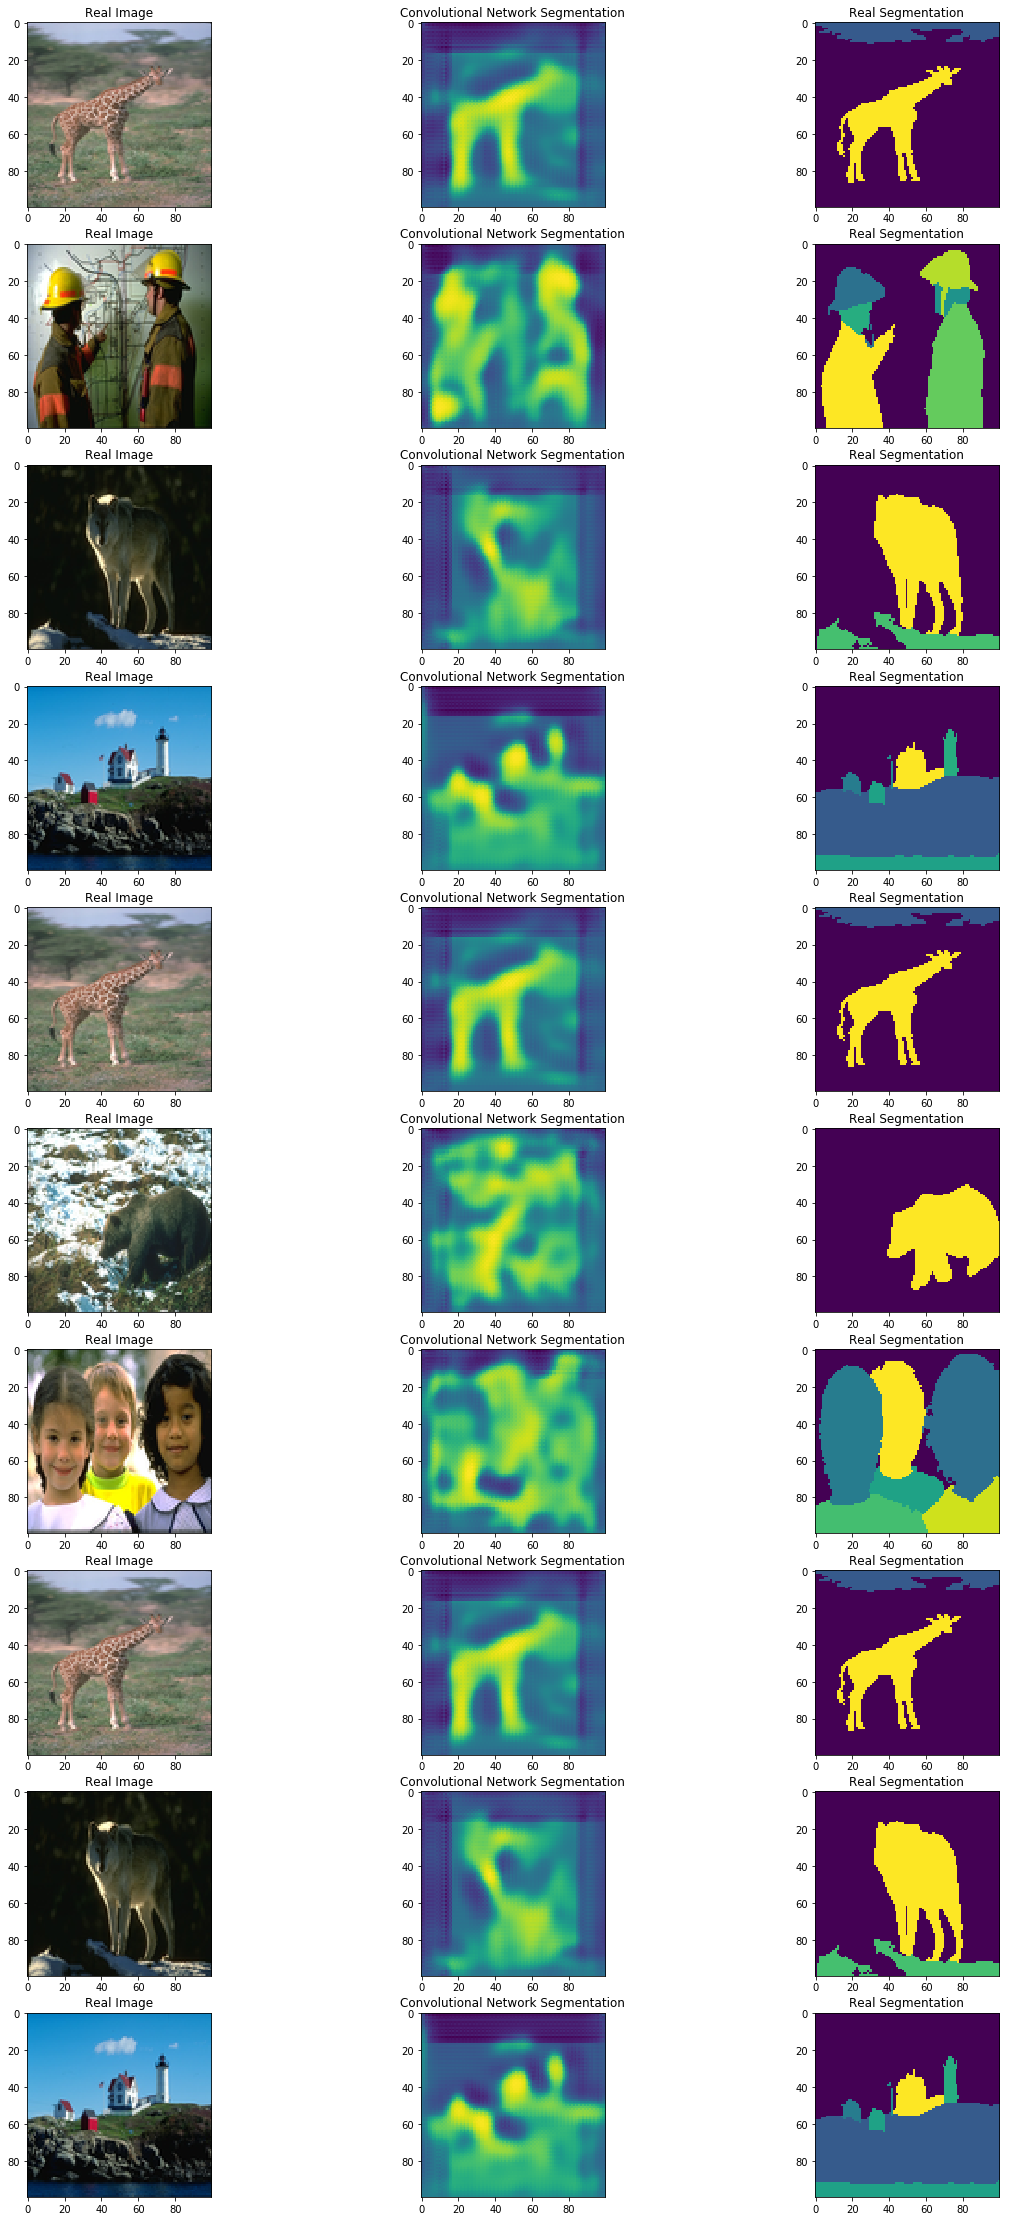

In [22]:
compare_images(conv_model)

> _**e) Compárese con alguna técnica manual de Image Segmentation, comúnmente se sugiere considerar un treshold para activar o apagar un pixel. Experimente con utilizar treshold igual a la media o con otra técnica más inteligente basada en los histogramas de escala de grises, como se utilizan en skimage.**_

In [23]:
#Gray-Scale
gray_x = 0.2125 * X_image[:,:,:,0] + 0.7154*X_image[:,:,:,1] + 0.0721*X_image[:,:,:,2]

In [24]:
treshold_mean = gray_x.mean()
mask_mean = gray_x < treshold_mean
x_mean_segmented = mask_mean*1

In [25]:
treshold_ski = filters.threshold_otsu(gray_x)
mask_ski = gray_x < treshold_ski
x_ski_segmented = mask_ski * 1

In [26]:
def compare_treshold(mean, ski):
    plt.figure(figsize=(30,40))
    for i in range(1,40,4):
        random = np.random.randint(0,X_image.shape[0])
        plt.subplot(10,4,i)
        plt.title("Real Image")
        plt.imshow(np.squeeze(X_image[random]))
        plt.subplot(10,4,i+1)
        plt.title("Mean Treshold Segmentation")
        plt.imshow(mean[random])
        plt.subplot(10,4,i+2)
        plt.title("Skimage Treshold Segmentation")
        plt.imshow(np.squeeze(ski[random]))
        plt.subplot(10,4,i+3)
        plt.title("Real Segmentation")
        plt.imshow(np.squeeze(Y_image[random]))
    plt.show()

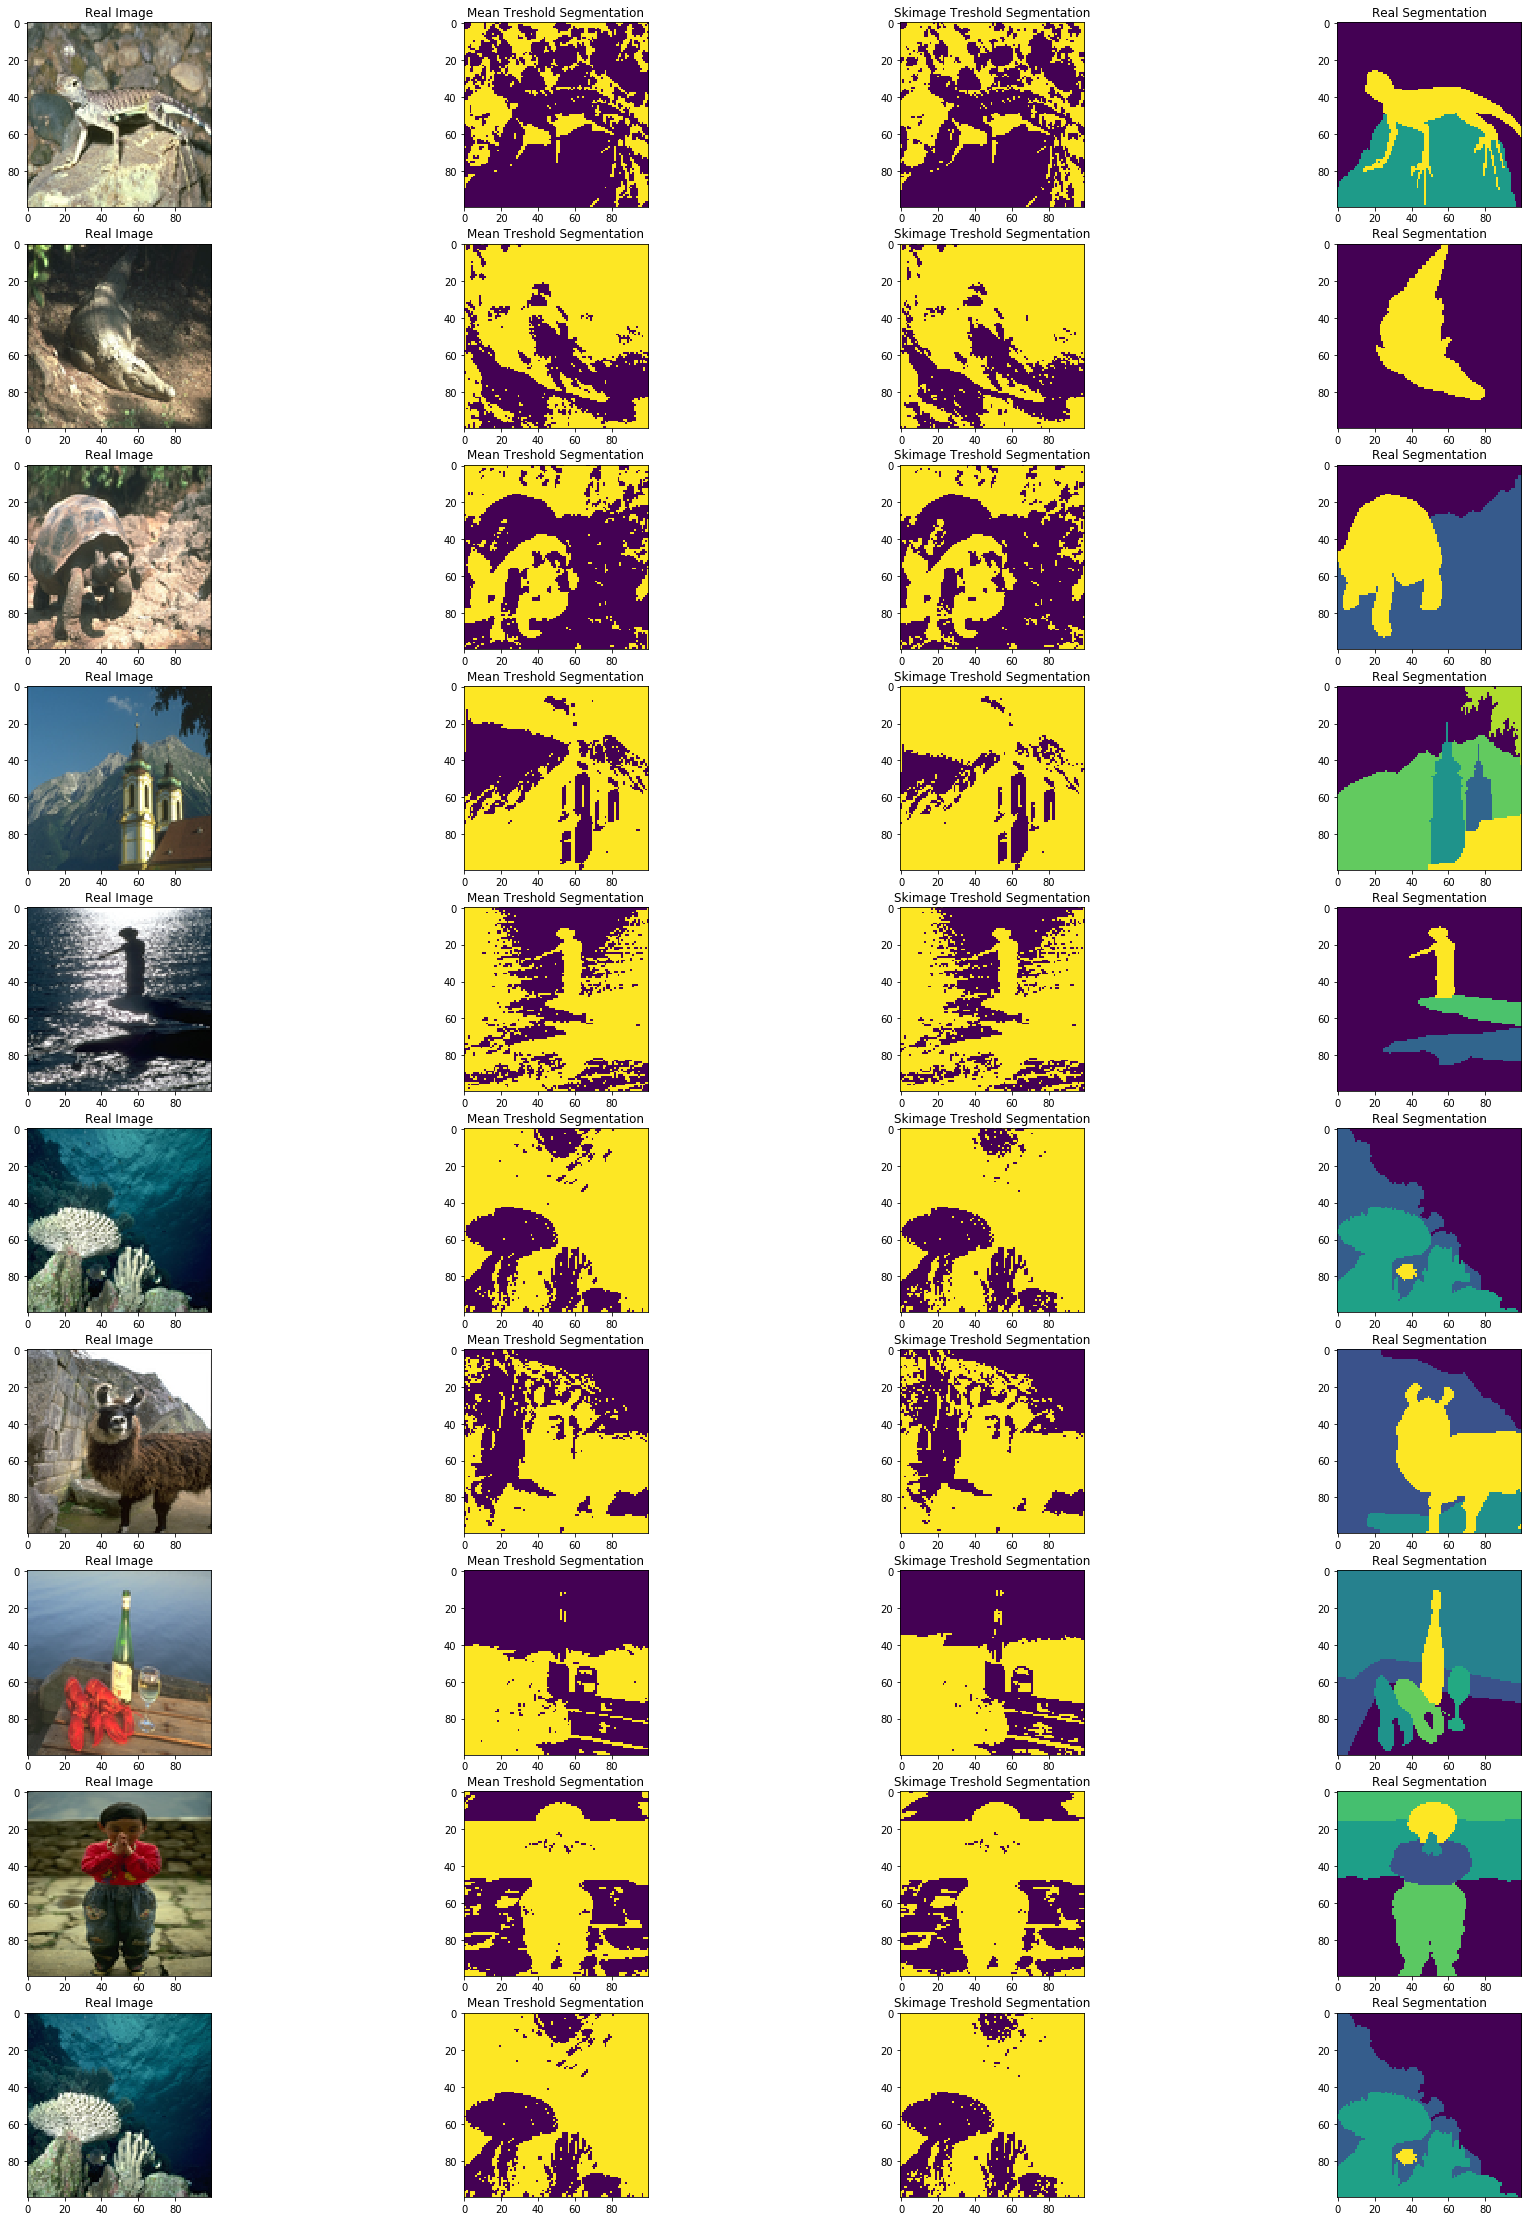

In [27]:
compare_treshold(x_mean_segmented,x_ski_segmented)

> _**f) Experimente con realizar data augmentation sobre el problema. Debido a que las operaciones clásifcas de augmentation como rotar, invertir, girar, cambiarían la etiqueta de segmentación, genere una estrategia que mantenga la etiqueta/salida Y. Se presenta un código de ejemplo, Denoising, de aplicar una máscara binaria aleatoria sobre la imagen de entrada X, de todas formas se espera que proponga alguna distinta. Compare el desempeño alcanzado con la nueva red con la forma de evaluar definida en (d).**_

In [28]:
def train_with_augmentation(model,aug):
#     pca = PCA(n_components = 3)
    for i in range(aug):
        x_aug = np.copy(x_train)
        for channel in range(3):
            channel_variation = np.ones(x_aug[:,:,:,channel].shape)*np.random.normal(loc=0,scale=1)
            x_aug[:,:,:,channel] += channel_variation/np.max(channel_variation)
            #x_aug[:,:,:,channel] = x_aug[:,:,:,channel] / np.max(x_aug[:,:,:,channel])
        model.fit(x_aug,y_train,epochs=1,batch_size=32,validation_data=(x_test,y_test))
    return model    
        
    

In [29]:
conv_model = train_with_augmentation(conv_model,100)

Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 4s 49ms/step - loss: 0.6114 - val_loss: 0.5908
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 2s 21ms/step - loss: 0.5463 - val_loss: 0.5822
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 2s 21ms/step - loss: 0.5338 - val_loss: 0.6070
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 2s 20ms/step - loss: 0.5274 - val_loss: 0.5868
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 2s 20ms/step - loss: 0.5300 - val_loss: 0.6165
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 2s 20ms/step - loss: 0.5016 - val_loss: 0.7020
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 2s 21ms/step - loss: 0.5386 - val_loss: 0.5588
Train 

Precision in train dataset: [0.81994029 0.57840177]
Recall in train dataset: [0.77628086 0.64291437]


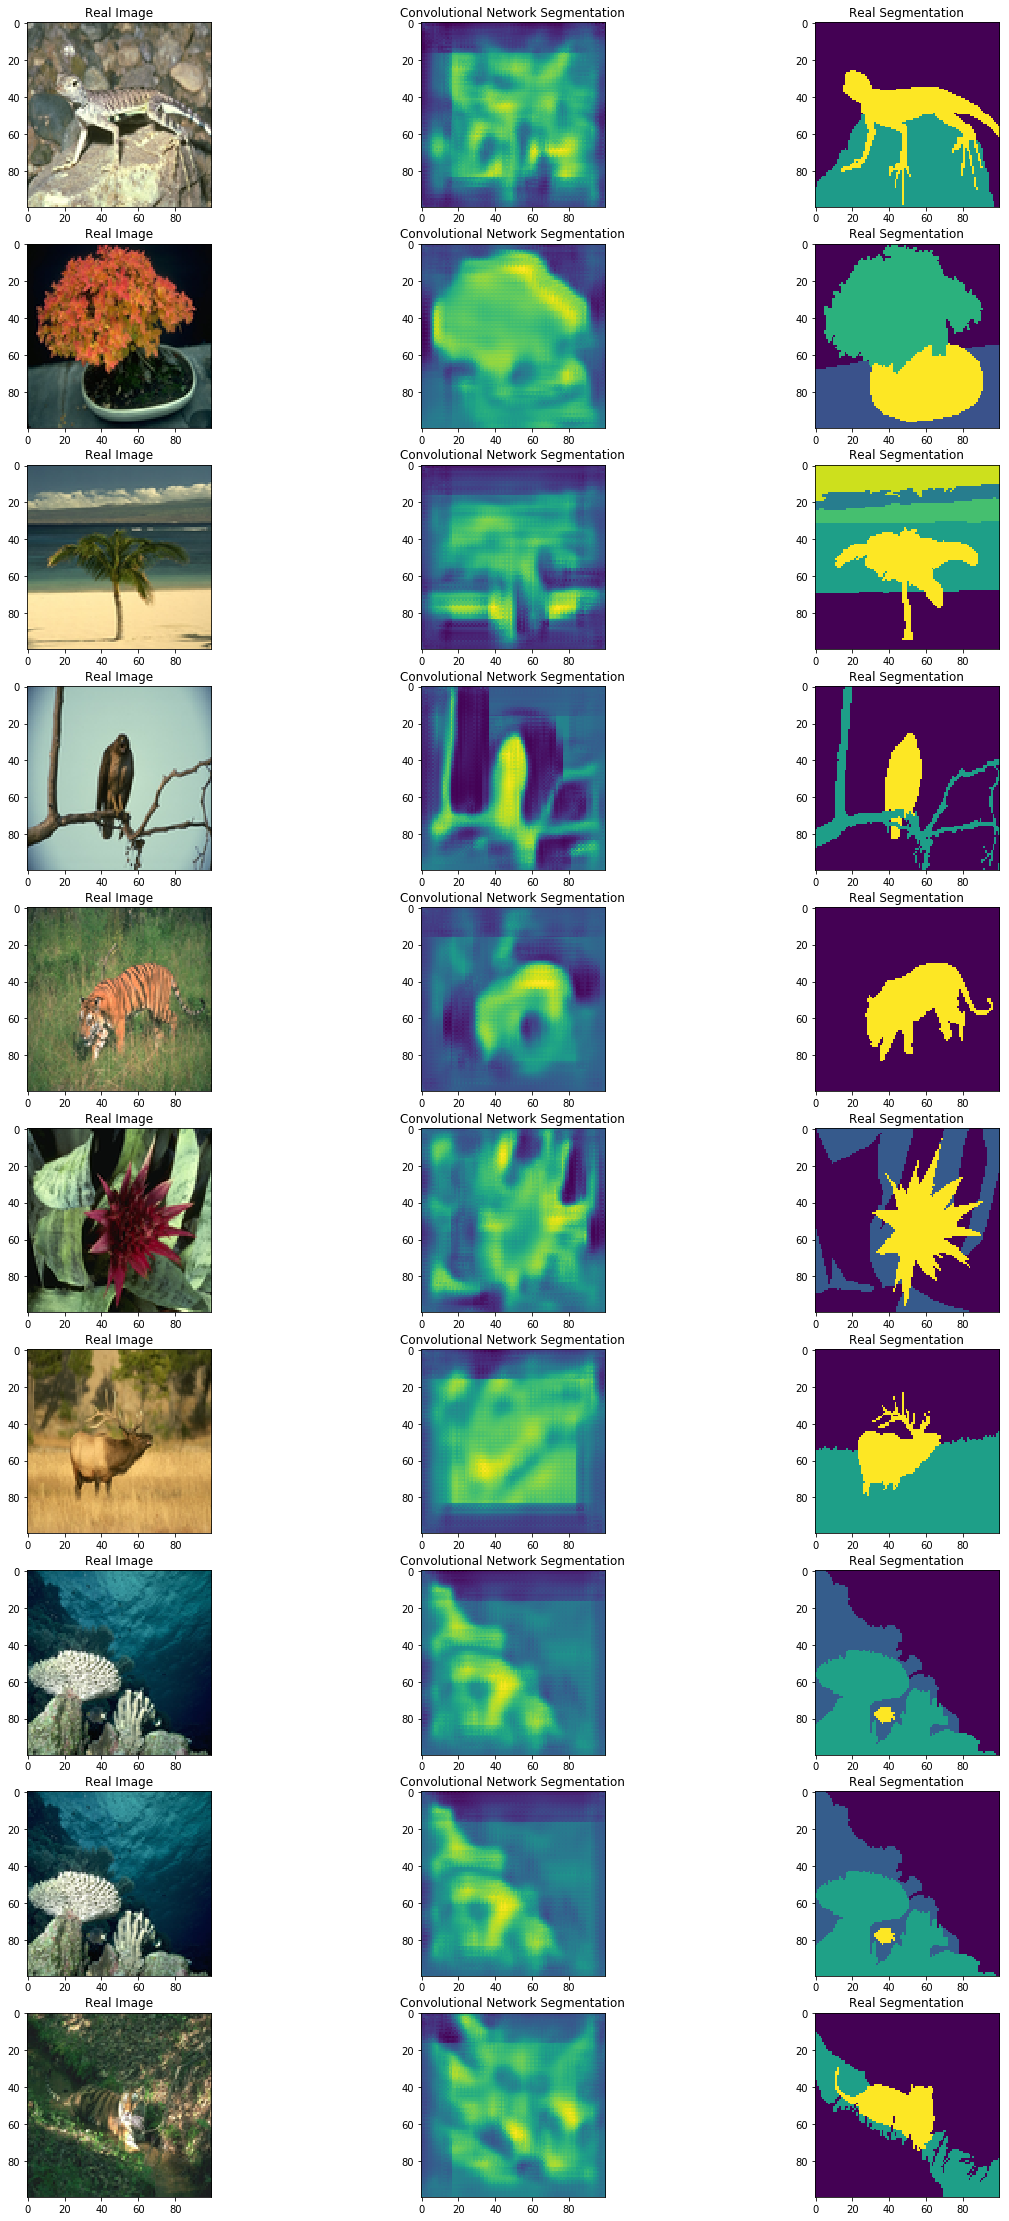

In [30]:
compare_images(conv_model,dataset='train')

Precision in test dataset: [0.781247   0.45975199]
Recall in test dataset: [0.7074826  0.55685754]


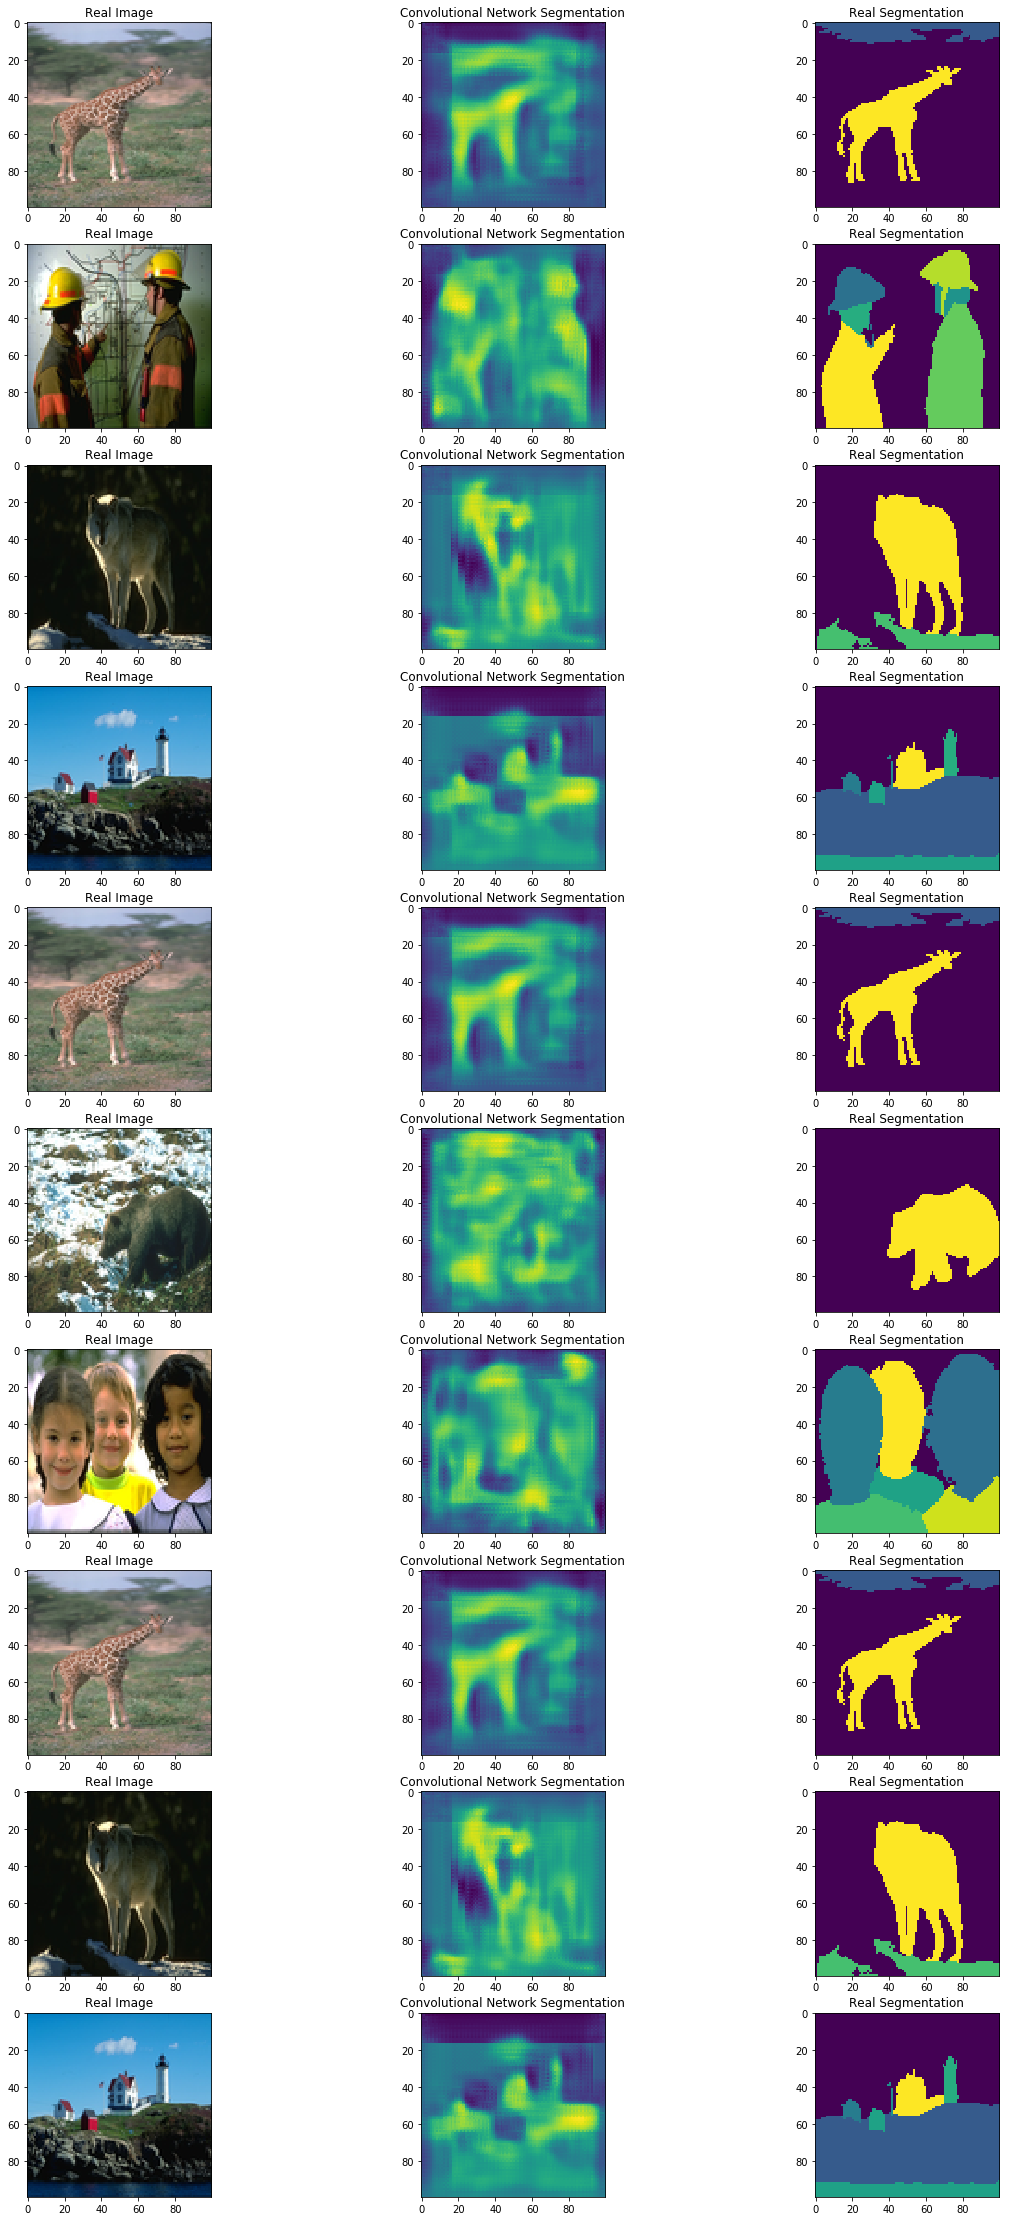

In [31]:
compare_images(conv_model)

In [32]:
def train_with_denoising(model,aug):
    for _ in range(aug):
        noise_level = np.random.randint(4,10)/10
        noise_mask = np.random.binomial(n=1,p=noise_level,size=X_image.shape)
        x_augmented = X_image*noise_mask
        model.fit(x_augmented,Y_image,epochs=1,batch_size=32,validation_data=(X_image,Y_image))
    return model

In [33]:
conv_model_denoising = get_convolutional()
conv_model_denoising.fit(x_train,y_train,epochs=100,batch_size=30,validation_data=(x_test,y_test))
conv_model_denoising = train_with_denoising(conv_model_denoising,100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 25, 25, 128)       73856     
__________

Epoch 63/100
90/90 [==============================] - 2s 21ms/step - loss: 0.5330 - val_loss: 0.5480
Epoch 64/100
90/90 [==============================] - 2s 21ms/step - loss: 0.4970 - val_loss: 0.5742
Epoch 65/100
90/90 [==============================] - 2s 21ms/step - loss: 0.6201 - val_loss: 0.5561
Epoch 66/100
90/90 [==============================] - 2s 20ms/step - loss: 0.5258 - val_loss: 0.5467
Epoch 67/100
90/90 [==============================] - 2s 21ms/step - loss: 0.5051 - val_loss: 0.5519
Epoch 68/100
90/90 [==============================] - 2s 21ms/step - loss: 0.5093 - val_loss: 0.5947
Epoch 69/100
90/90 [==============================] - 2s 21ms/step - loss: 0.5058 - val_loss: 0.5453
Epoch 70/100
90/90 [==============================] - 2s 21ms/step - loss: 0.5213 - val_loss: 0.5593
Epoch 71/100
90/90 [==============================] - 2s 21ms/step - loss: 0.4965 - val_loss: 0.6170
Epoch 72/100
90/90 [==============================] - 2s 21ms/step - loss: 0.5057 - val_los

100/100 [==============================] - 3s 26ms/step - loss: 0.4719 - val_loss: 0.5293
Train on 100 samples, validate on 100 samples
Epoch 1/1
100/100 [==============================] - 3s 26ms/step - loss: 0.5246 - val_loss: 0.7616
Train on 100 samples, validate on 100 samples
Epoch 1/1
100/100 [==============================] - 3s 26ms/step - loss: 0.5990 - val_loss: 0.4822
Train on 100 samples, validate on 100 samples
Epoch 1/1
100/100 [==============================] - 3s 26ms/step - loss: 0.4781 - val_loss: 0.4822
Train on 100 samples, validate on 100 samples
Epoch 1/1
100/100 [==============================] - 3s 26ms/step - loss: 0.4858 - val_loss: 0.5663
Train on 100 samples, validate on 100 samples
Epoch 1/1
100/100 [==============================] - 3s 26ms/step - loss: 0.5243 - val_loss: 0.5119
Train on 100 samples, validate on 100 samples
Epoch 1/1
100/100 [==============================] - 3s 26ms/step - loss: 0.4826 - val_loss: 0.4682
Train on 100 samples, validate on 

Precision in train dataset: [0.76950813 0.80300752]
Recall in train dataset: [0.95290547 0.40212364]


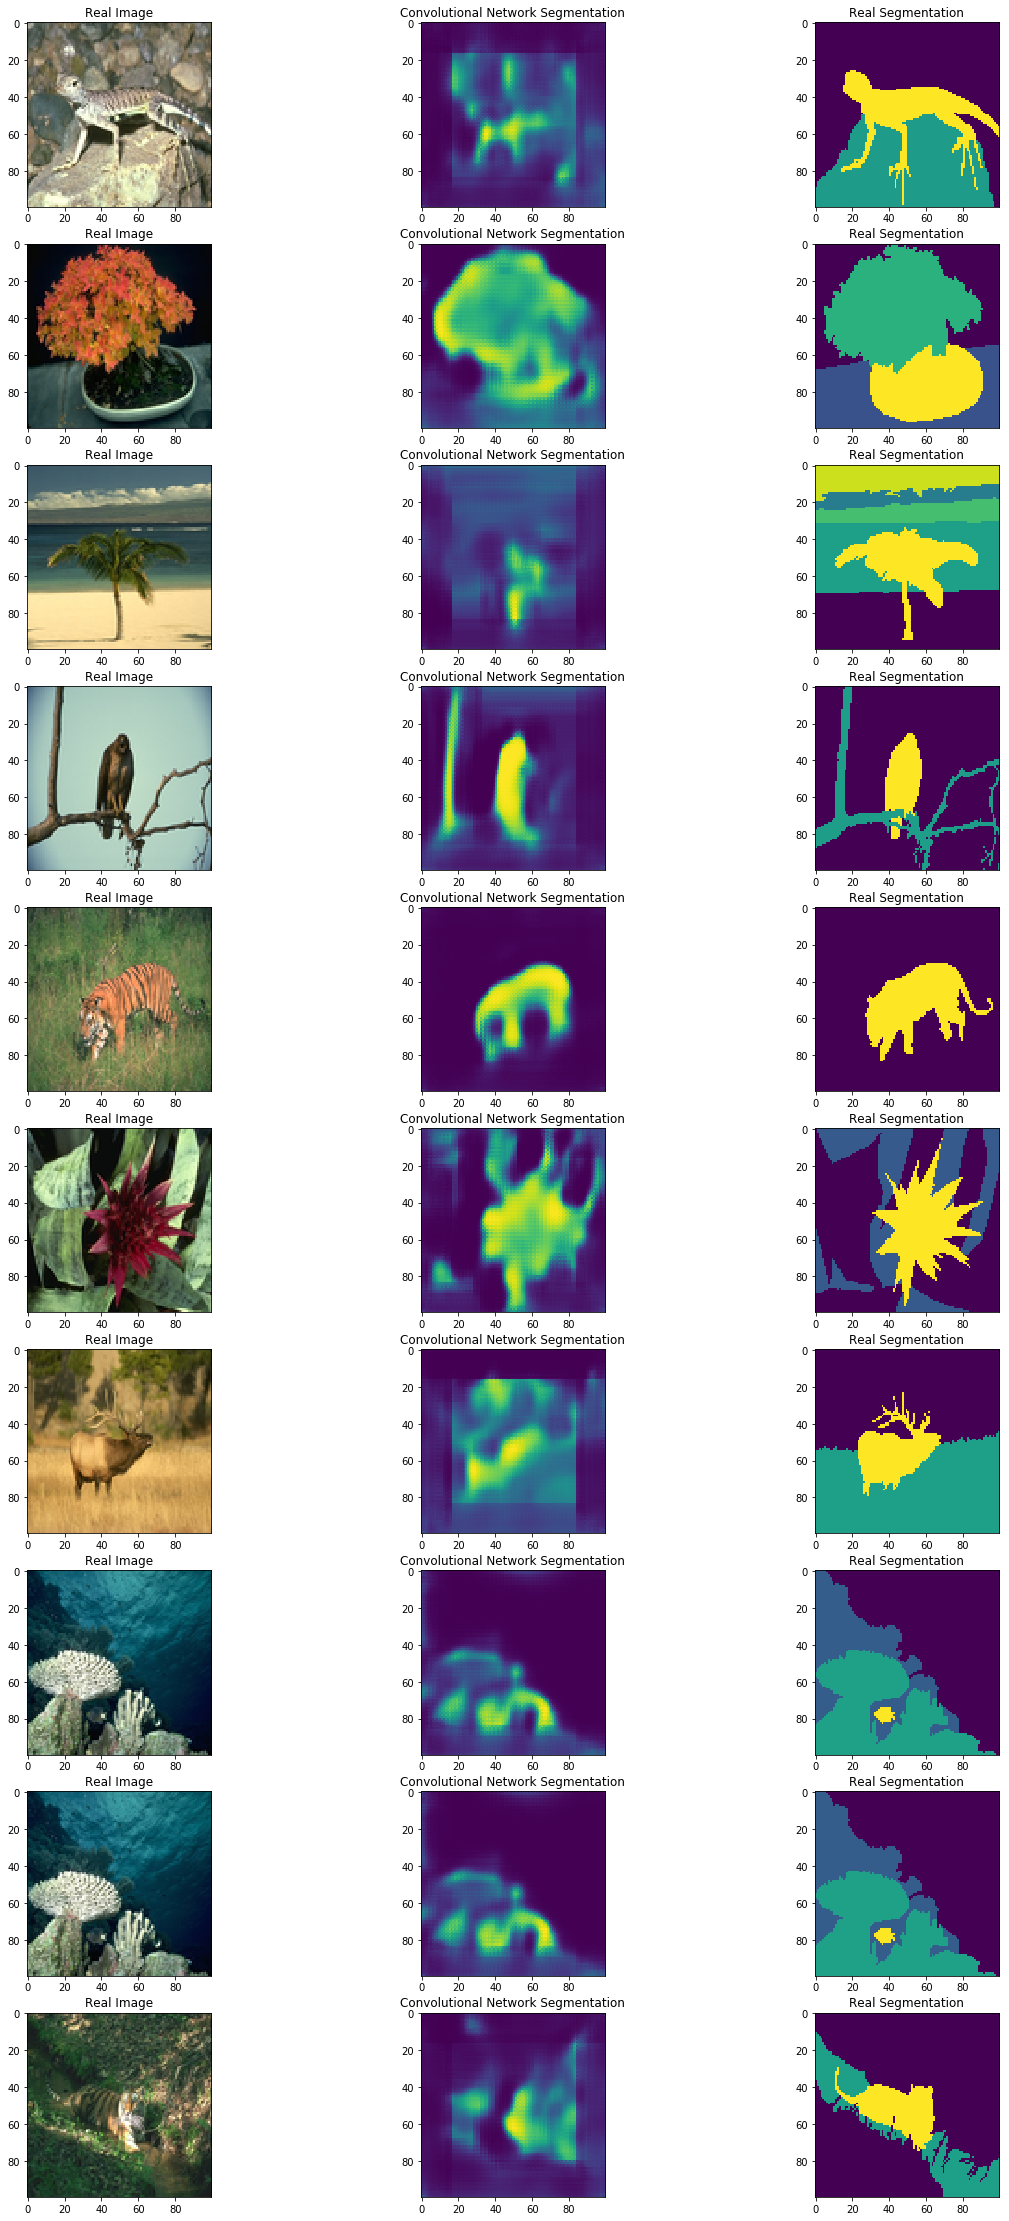

In [34]:
compare_images(conv_model_denoising,dataset='train')

Precision in test dataset: [0.76191456 0.6449575 ]
Recall in test dataset: [0.91054452 0.36351277]


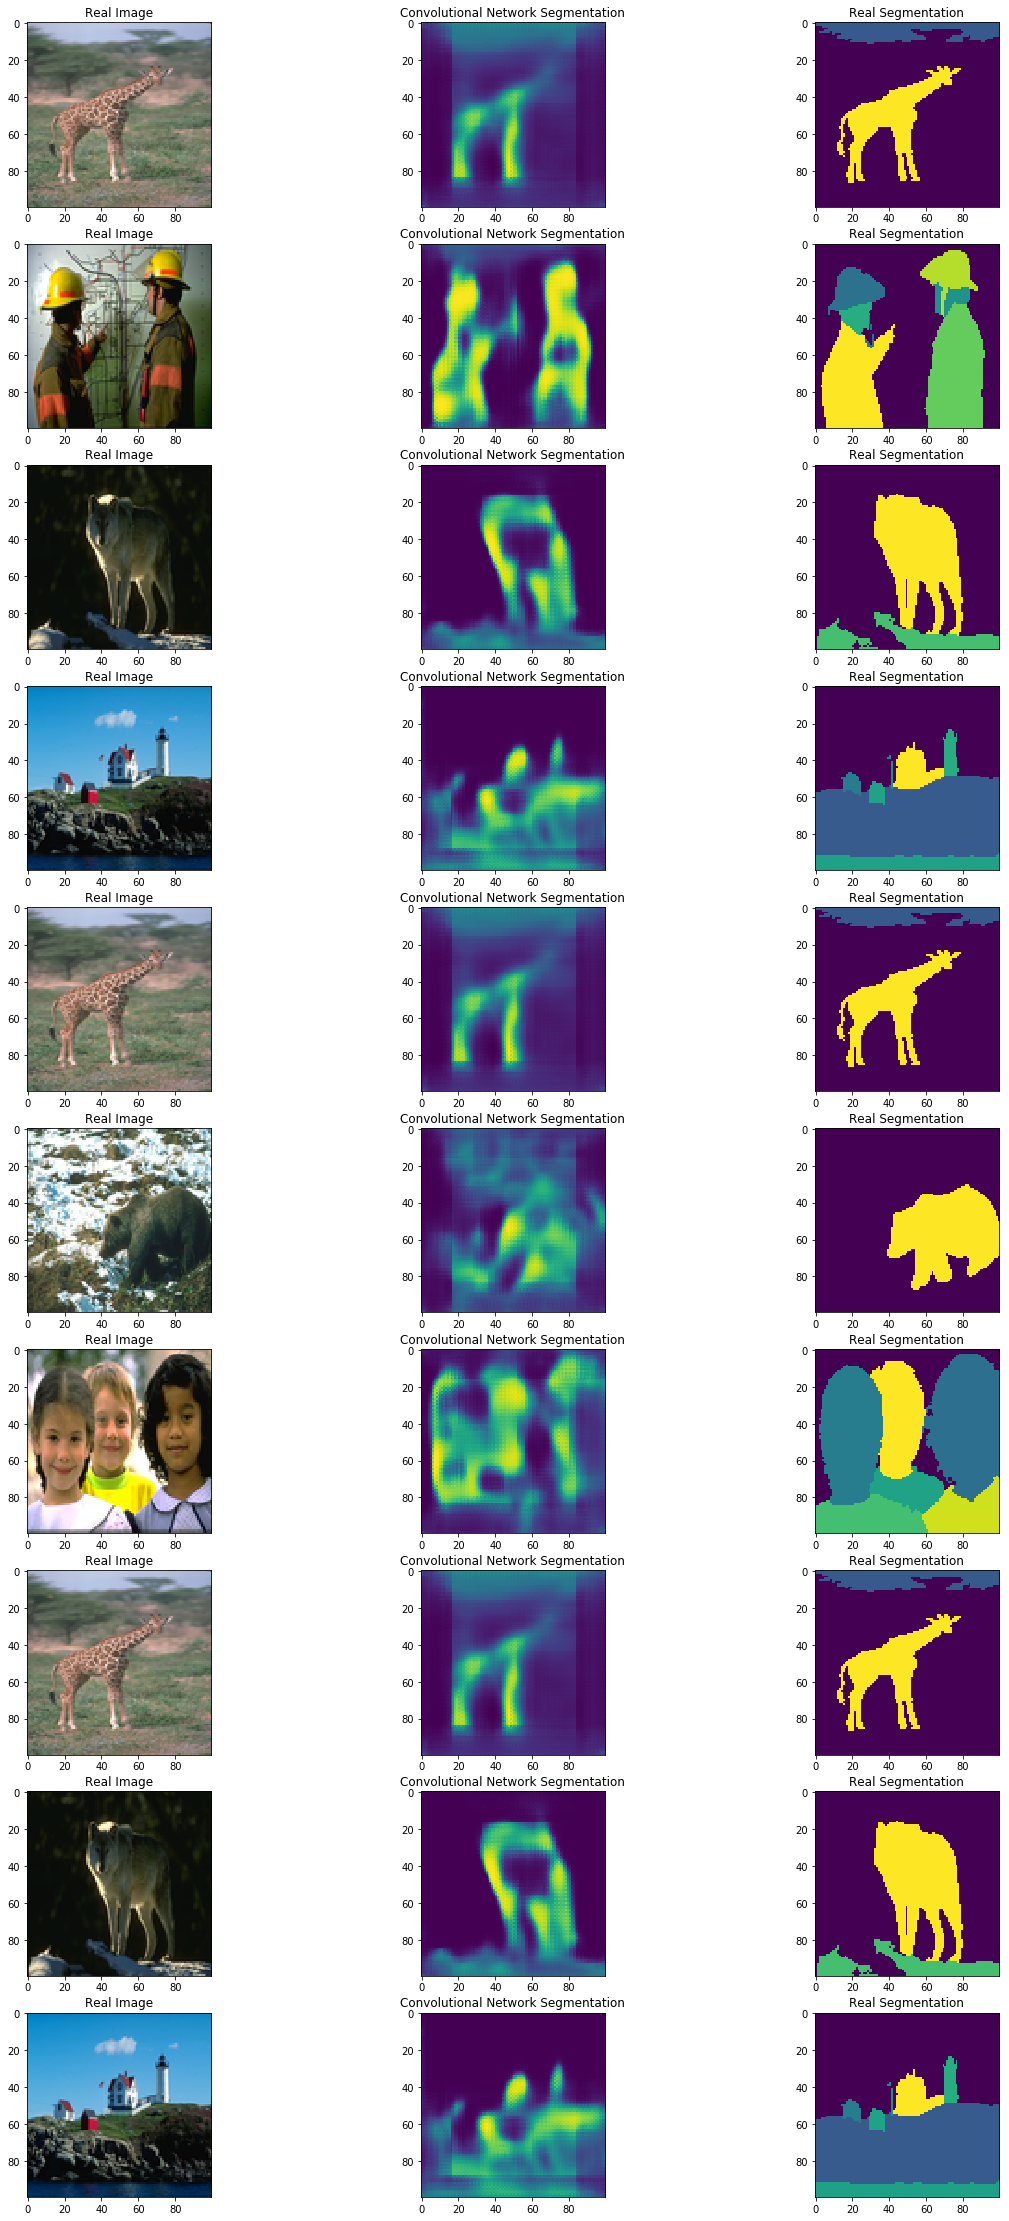

In [35]:
compare_images(conv_model_denoising)

In [88]:
# data_gen_args = dict(featurewise_center=True,
#                     featurewise_std_normalization=True,
#                     rotation_range=90.,
#                     width_shift_range=0.1,
#                     height_shift_range=0.1,
#                     zoom_range=0.2)

# image_datagen = ImageDataGenerator(**data_gen_args)
# mask_datagen = ImageDataGenerator(**data_gen_args)

# image_datagen.fit(x_train,augment=True,seed=42)
# mask_datagen.fit(y_train,augment=True,seed=42)

# train_generator = zip(image_datagen.flow(x_train),mask_datagen.flow(y_train))

# model_2 = get_convolutional()
# model_2.fit_generator(train_generator,samples_per_epoch=100,nb_epoch=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_66 (Conv2D)           (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 25, 25, 128)       73856     
__________

c:\mauro\redesn~1\env\lib\site-packages\ipykernel_launcher.py:17: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
c:\mauro\redesn~1\env\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<zip objec..., epochs=100, steps_per_epoch=100)`


Epoch 1/100
100/100 [==============================] - 54s 539ms/step - loss: -0.1089
Epoch 2/100
100/100 [==============================] - 50s 502ms/step - loss: -0.0872
Epoch 3/100
100/100 [==============================] - 50s 501ms/step - loss: -0.1151
Epoch 4/100
  6/100 [>.............................] - ETA: 46s - loss: -0.1341

KeyboardInterrupt: 

> _**g) Intente variar la arquitectura presentada en pos de obtener un mejor modelo, basado en la evaluación realizada en (d). Recuerde tomar en cuenta la poca cantidad de datos que se tiene.**_

In [41]:
resnet_model = ResNet50(include_top=False,weights='imagenet',input_shape=img_shape)

c:\mauro\redesn~1\env\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 148s 2us/step


In [199]:
input_layer = Input(shape=img_shape)
#Encoder Part
conv_layer = Conv2D(32,(3,3),activation='relu',padding='same')(input_layer)
pooling_1 = MaxPool2D((2,2))(conv_layer)
conv_layer2 = Conv2D(64,(3,3),activation='relu',padding='same')(pooling_1)
batch_norm_2 = BatchNormalization()(conv_layer2)
pooling_2 = MaxPool2D((2,2))(batch_norm_2)
conv_layer3 = Conv2D(128,(3,3),activation='relu',padding='same')(pooling_2)

#Decoder Part
up_sampling = UpSampling2D((2,2))(conv_layer3)
#Here comes a skip connection

conv = Conv2D(128,(1,1),padding='same')(conv_layer2)
batch_norm_5 = BatchNormalization()(conv)
add_layer = merge.Add()([batch_norm_5,up_sampling])
conv_trans = Conv2DTranspose(32,(3,3),activation='relu',padding='same')(add_layer)
batch_norm_3 = BatchNormalization()(conv_trans)
conv_trans = Conv2DTranspose(32,(3,3),activation='relu',padding='same')(batch_norm_3)
batch_norm_4 = BatchNormalization()(conv_trans)
merge_layer = merge.Add()([pooling_1,batch_norm_4])
up_sampling_2 = UpSampling2D((2,2))(merge_layer)
conv_trans_2 = Conv2DTranspose(32,(3,3),activation='relu',padding='same')(up_sampling_2)
#merge_layer_2 = merge.Add()([conv_layer,conv_trans_2])
output = Conv2DTranspose(1,(3,3),activation='sigmoid',padding='same')(conv_trans_2)

In [144]:
def focal_loss(gamma,alpha):
    def loss(y_true,y_pred):
        y_true = K.clip(y_true, K.epsilon(), 1)
        y_pred = K.clip(y_pred,K.epsilon(),1)
        return K.sum(-alpha*(y_true*K.pow(1 - y_pred,gamma)*K.log(y_pred) + (1 - y_true)*K.pow(y_pred,gamma)*K.log(1 - y_pred)),axis=-1)
#         return K.sum(-alpha*((1-y_true)*K.pow(1 - y_pred,gamma)*K.log(y_pred) + (y_true)*K.pow(y_pred,gamma)*K.log(1 - y_pred)),axis=-1)
    return loss

In [200]:
conv_propio = Model(input_layer,output)
conv_propio.summary()


# SVG(model_to_dot(conv_propio).create(prog='dot', format='svg'))

conv_propio.compile(loss='binary_crossentropy',optimizer='adam')
hist = conv_propio.fit(x_train,y_train,epochs=100,batch_size=32,validation_data=(x_test,y_test),verbose=0)
# conv_propio = train_with_denoising(conv_propio,100)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv2d_137 (Conv2D)             (None, 100, 100, 32) 896         input_37[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_79 (MaxPooling2D) (None, 50, 50, 32)   0           conv2d_137[0][0]                 
__________________________________________________________________________________________________
conv2d_138 (Conv2D)             (None, 50, 50, 64)   18496       max_pooling2d_79[0][0]           
__________________________________________________________________________________________________
batch_norm

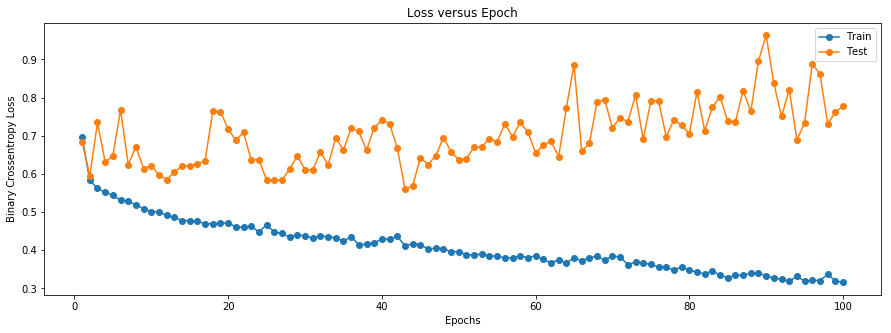

In [201]:
loss_versus_epoch(hist)

In [169]:
conv_propio.save('segmenters/43-56.h5')

Precision in train dataset: [0.84760368 0.80161815]
Recall in train dataset: [0.92292085 0.65241162]


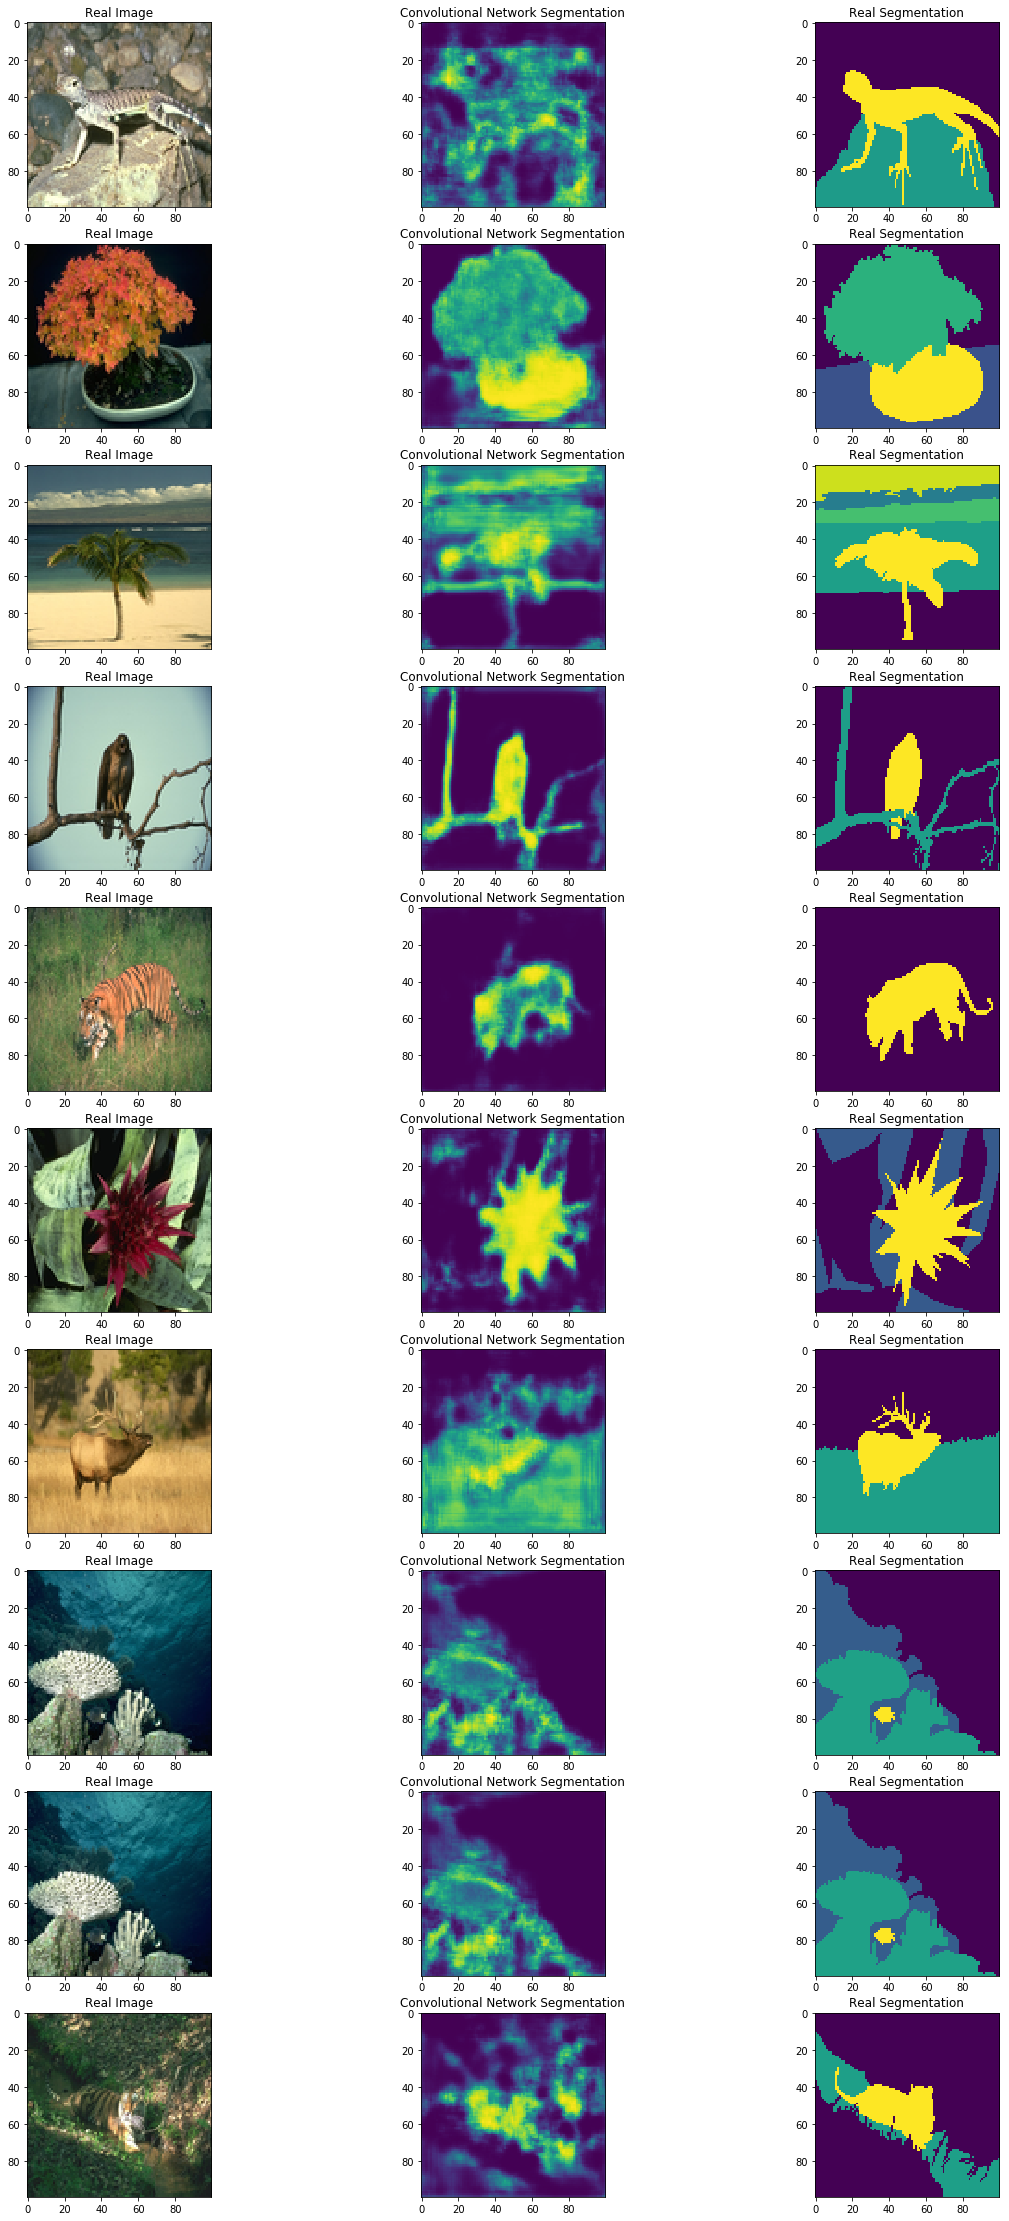

In [202]:
compare_images(conv_propio,dataset='train')

Precision in test dataset: [0.74138183 0.46116993]
Recall in test dataset: [0.80632932 0.37079597]


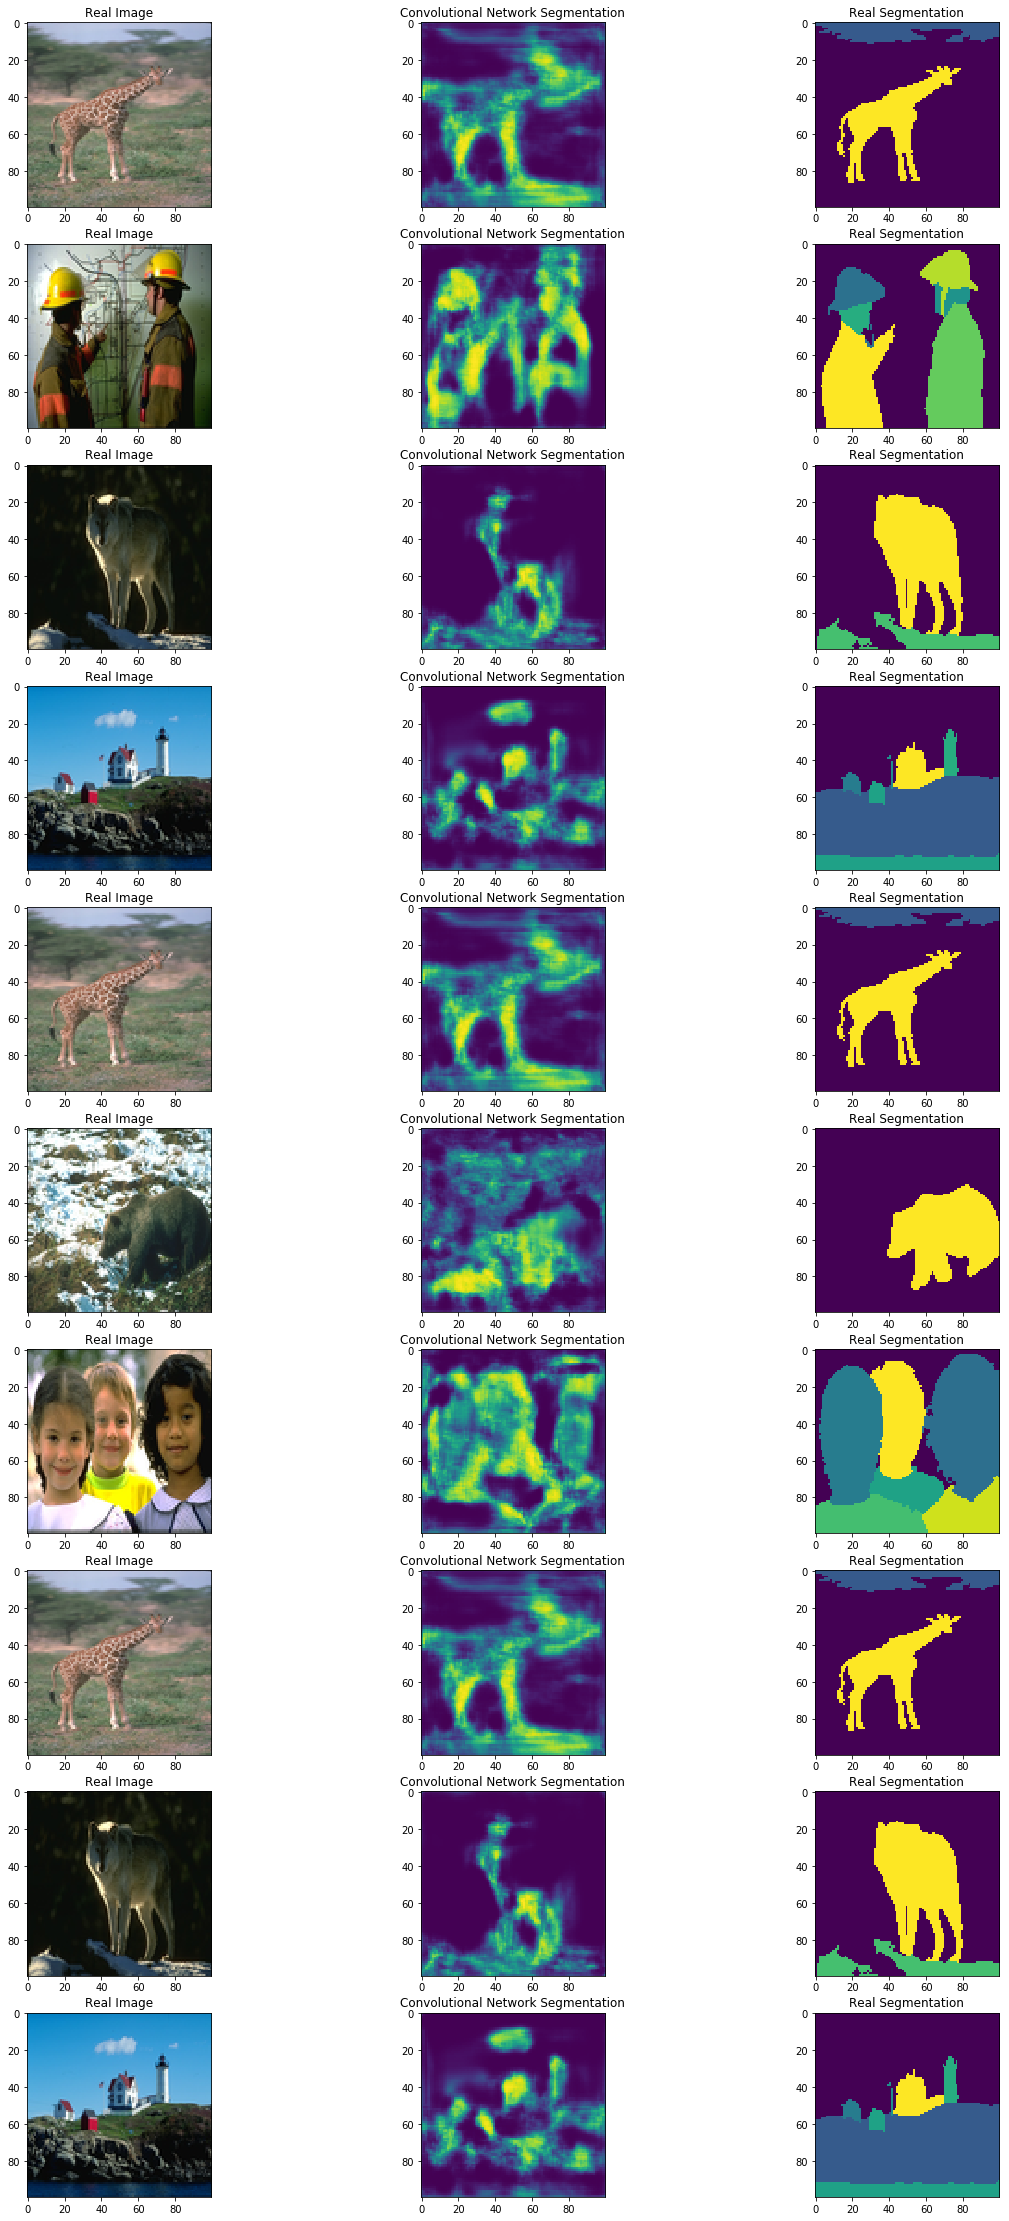

In [203]:
compare_images(conv_propio)